In [1]:
import pandas as pd
import pytz
import datetime as dt
import math
import seaborn as sns
import matplotlib as mpl
#mpl.rcParams['path.simplify'] = False
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def read_manipulate_psychopy(psychopy_path):
    
    psychopy_df = pd.read_csv(psychopy_path)
    col_list = [col for col in psychopy_df.columns if col.endswith('_ts')]
    col_list.insert(0, "Reference_time")
    psychopy_df_selected = psychopy_df[col_list]
    
    return psychopy_df_selected    


def read_shimmer_sensor(sensor_file_path):
    
    shimmer_df = pd.read_csv(sensor_file_path, sep='\t', low_memory=False)
    shimmer_df = shimmer_df.reset_index()
    shimmer_df.columns = shimmer_df.iloc[0]
    shimmer_df.drop([0, 1], axis=0, inplace=True)
    shimmer_df=shimmer_df.reset_index(drop=True)
    
    return shimmer_df

def standardize_timestamps_shimmer(shimmer_df, timestamps_col_name):
    
    timesstamps_list = shimmer_df[timestamps_col_name].to_list()
    new_timestamps_list = [float(val)/1000 for val in  timesstamps_list]
    
    shimmer_df[timestamps_col_name] = new_timestamps_list
    
    return shimmer_df

def get_nonNan_list_psychopy(psychopy_df, col_name):
    
    
    selected_vals=[val for val in psychopy_df[col_name].to_list() if not(math.isnan(val))]
    
    return selected_vals


def get_offset_timestamp(timestamp, offset_mins):
    
    time_zone = 'Europe/Berlin'
    tz = pytz.timezone(time_zone)
    local_time = dt.datetime.fromtimestamp(timestamp, tz)
    time_change = dt.timedelta(minutes=offset_mins)
    new_time = local_time + time_change
    new_timestamp =  dt.datetime.timestamp(new_time)
    return new_timestamp
    
def slice_df_wrt_timestamps(df, start_timestamp, end_timestamp, timestamps_col):
    
    sliced_df=df[(df[timestamps_col]>= start_timestamp) & (df[timestamps_col] <= end_timestamp)]
    
    return sliced_df

def normalize_data (std_df, signal_col):
    
    
    signal = std_df[signal_col].to_list()
    
    
    signal_float =[float(val) for val in signal]
    
    signal_float_np = np.array(signal_float)
    
    
    mean_signal = np.mean(signal_float_np)
    
    mean_sub = signal_float_np - mean_signal
    
    scaled_data =  mean_sub/np.max(np.abs(mean_sub))
    
    std_df["mean_norm"] = scaled_data
    
    return std_df

def mean_std_col_df (df, col_name):
    
    col_list = df[col_name].to_list()
    
    cols_list_float = [float(val) for val in col_list]
    
    cols_list_float_np =np.array(cols_list_float)
    
    mean_col= np.mean(cols_list_float_np)
    std_col = np.std(cols_list_float_np)
    
    return mean_col, std_col


def plot_mean_std(mean_list, std_list, label_list, title_figure, y_label_fig):
    x_pos = np.arange(len(label_list))
    fig, ax = plt.subplots()
    ax.bar(x_pos, mean_list, yerr=std_list, align='center', alpha=0.5, capsize=10 )
    ax.set_ylabel(y_label_fig)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(label_list, rotation=45, ha='right', rotation_mode='anchor')
    #title_ax = "VP001_251023_Session1_Shimmer_FBA7_Calibrated_SD"
    ax.set_title(title_figure)
    ax.yaxis.grid(True)
    plt.tight_layout()
    plt.show()
    
    
    

def get_mean_std_list_differrent_events(event_interest_list, offset_min_list, psychopy_df, sensor_df, timestamp_sensor_col_name, data_col_name):


    mean_cumm_list = []
    std_cumm_list  = []

    event_interets_plot = []
    
    for ii, event_interest in enumerate(event_interest_list):
        event_plot = event_interest +" "+ (str(offset_min_list[ii])) + " min"
    
        print(event_plot)
        event_interets_plot.append(event_plot)
    
        #add_me = 
        #event_interest_list_plot = 
    
        current_event_timestamp = get_nonNan_list_psychopy(psychopy_df, event_interest)[0]
        offset_min = offset_min_list[ii]
        timestamp_offset = get_offset_timestamp(current_event_timestamp, offset_min)
    
        print(dt.datetime.fromtimestamp(current_event_timestamp, tz))
        print(dt.datetime.fromtimestamp(timestamp_offset, tz))
    
        start_end_time_list = [current_event_timestamp, timestamp_offset]
    
        timestamp_start_slice = min(start_end_time_list)
    
        timestamp_end_slice = max(start_end_time_list)
    
        sensor_df_ii=slice_df_wrt_timestamps(sensor_df, timestamp_start_slice, timestamp_end_slice, timestamp_sensor_col_name)
        
        mean_val, std_val = mean_std_col_df(sensor_df_ii, data_col_name) 
        mean_cumm_list.append(mean_val)
        std_cumm_list.append(std_val)
        
    
    
    return mean_cumm_list, std_cumm_list, event_interets_plot
    
    
    

In [23]:
event_interest_list

['sam_e_ts',
 'tsst_prep_ts',
 'tsst_end_ts',
 'tsst_end_ts',
 'saliva_probe_3_ts',
 'saliva_probe_3_ts',
 'saliva_probe_3_ts',
 'saliva_probe_3_ts']

In [25]:
offset_min_list

[-4, 5, -5, -10, -20, -15, -10, -5]

In [26]:
event_interest_list_new = ["sam_e_ts", "tsst_prep_ts", "tsst_end_ts", "saliva_probe_3_ts"]
offset_min_list_new = [[-4], [5], [-5, -10], [-20, -15, -10, -5]]

In [42]:

mean_cumm_list = []
std_cumm_list  = []
event_interets_plot = []


##---outer loop to hnadle muultiple offsets from the selected events 
for ind, event_selected in enumerate(event_interest_list_new):
    
    offset_list_selected_event = offset_min_list_new[ind]
    
    print(event_selected)
    
    current_event_timestamp = get_nonNan_list_psychopy(psychopy_df, event_selected)[0]
    
    offset_min = offset_min_list_new[ind]
    
    for offset_min in offset_list_selected_event:
        
        #print(ofset)
        event_plot = event_selected +" "+ str(offset_min) + " min"
        timestamp_offset = get_offset_timestamp(current_event_timestamp, offset_min)
        
        
        
        
        print(event_plot)
        
        
        
     
    
    #for offset in offset_list_selected_event:
        
    #    event_plot = event_selected +" "+ (str(offset) + " min"
    

sam_e_ts
sam_e_ts -4 min
tsst_prep_ts
tsst_prep_ts 5 min
tsst_end_ts
tsst_end_ts -5 min
tsst_end_ts -10 min
saliva_probe_3_ts
saliva_probe_3_ts -20 min
saliva_probe_3_ts -15 min
saliva_probe_3_ts -10 min
saliva_probe_3_ts -5 min


### Paths

In [3]:
psychopy_file_path = "D:/Datasets/data_sony_digiRelax/pilot_study/VP002_261023/Psychopy_data/VP002_261023_DigiRelax_Experiment_2023-10-26_10h12.28.142.csv"
skin_shimmer_file_path =  "D:/Datasets/data_sony_digiRelax/pilot_study/VP002_261023/Shimmer_data/2023-10-26_08.29.09_VP002_261023_SD_Session1/VP002_261023_Session1_Shimmer_FBA7_Calibrated_SD.csv"
hr_shimmer_file_path = "D:/Datasets/data_sony_digiRelax/pilot_study/VP002_261023/Shimmer_data/2023-10-26_08.29.09_VP002_261023_SD_Session1/VP002_261023_Session1_Shimmer_8108_Calibrated_SD.csv"

## ---- read psychopy df

In [4]:
psychopy_df = read_manipulate_psychopy(psychopy_file_path)

In [5]:
time_zone = 'Europe/Berlin'
tz = pytz.timezone(time_zone)

## skin conductance

In [6]:
title_figure = "VP002_261023_DigiRelax_Experiment_2023-10-26_10h12.28.142.csv"

sam_e_ts -4 min
2023-10-26 10:16:45.767557+02:00
2023-10-26 10:12:45.767557+02:00
tsst_prep_ts 5 min
2023-10-26 10:22:26.363398+02:00
2023-10-26 10:27:26.363398+02:00
tsst_end_ts -5 min
2023-10-26 10:38:19.044439+02:00
2023-10-26 10:33:19.044439+02:00
tsst_end_ts -10 min
2023-10-26 10:38:19.044439+02:00
2023-10-26 10:28:19.044439+02:00
saliva_probe_3_ts -20 min
2023-10-26 11:04:20.269308+02:00
2023-10-26 10:44:20.269308+02:00
saliva_probe_3_ts -15 min
2023-10-26 11:04:20.269308+02:00
2023-10-26 10:49:20.269308+02:00
saliva_probe_3_ts -10 min
2023-10-26 11:04:20.269308+02:00
2023-10-26 10:54:20.269308+02:00
saliva_probe_3_ts -5 min
2023-10-26 11:04:20.269308+02:00
2023-10-26 10:59:20.269308+02:00


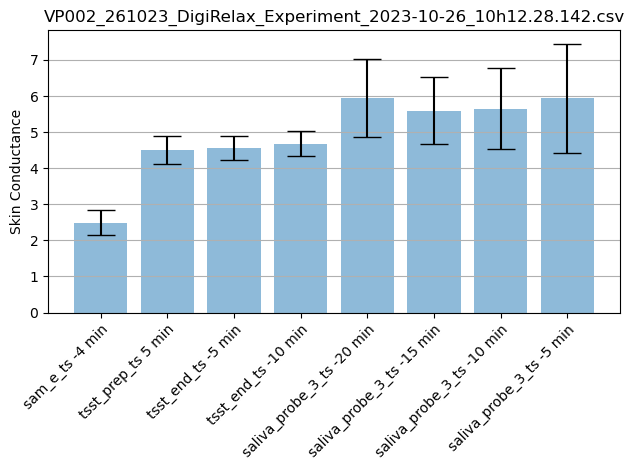

In [7]:

skin_resis_shimmer_df = read_shimmer_sensor(skin_shimmer_file_path)
skin_resis_shimmer_df = standardize_timestamps_shimmer(skin_resis_shimmer_df, "Shimmer_FBA7_Timestamp_Unix_CAL")
skin_col_interest  = ["Shimmer_FBA7_Timestamp_Unix_CAL", "Shimmer_FBA7_GSR_Skin_Conductance_CAL"]
skin_resis_shimmer_df_selected =skin_resis_shimmer_df[skin_col_interest]


##-------------------------------
event_interest_list = ["sam_e_ts", "tsst_prep_ts", "tsst_end_ts", "tsst_end_ts", "saliva_probe_3_ts", "saliva_probe_3_ts", "saliva_probe_3_ts", "saliva_probe_3_ts"]
offset_min_list = [-4, 5, -5, -10, -20, -15, -10, -5]
sensor_df= skin_resis_shimmer_df_selected

####----------------------------------------------
timestamp_sensor_col_name = "Shimmer_FBA7_Timestamp_Unix_CAL"
data_col_name = "Shimmer_FBA7_GSR_Skin_Conductance_CAL"


mean_list_sk, std_list_sk, event_interest_list_sk = get_mean_std_list_differrent_events(event_interest_list, offset_min_list,psychopy_df, sensor_df, timestamp_sensor_col_name, data_col_name)
y_label_fig = "Skin Conductance"
plot_mean_std(mean_list_sk, std_list_sk, event_interest_list_sk, title_figure, y_label_fig)

## Heart rate data

sam_e_ts -4 min
2023-10-26 10:16:45.767557+02:00
2023-10-26 10:12:45.767557+02:00
tsst_prep_ts 5 min
2023-10-26 10:22:26.363398+02:00
2023-10-26 10:27:26.363398+02:00
tsst_end_ts -5 min
2023-10-26 10:38:19.044439+02:00
2023-10-26 10:33:19.044439+02:00
tsst_end_ts -10 min
2023-10-26 10:38:19.044439+02:00
2023-10-26 10:28:19.044439+02:00
saliva_probe_3_ts -20 min
2023-10-26 11:04:20.269308+02:00
2023-10-26 10:44:20.269308+02:00
saliva_probe_3_ts -15 min
2023-10-26 11:04:20.269308+02:00
2023-10-26 10:49:20.269308+02:00
saliva_probe_3_ts -10 min
2023-10-26 11:04:20.269308+02:00
2023-10-26 10:54:20.269308+02:00
saliva_probe_3_ts -5 min
2023-10-26 11:04:20.269308+02:00
2023-10-26 10:59:20.269308+02:00


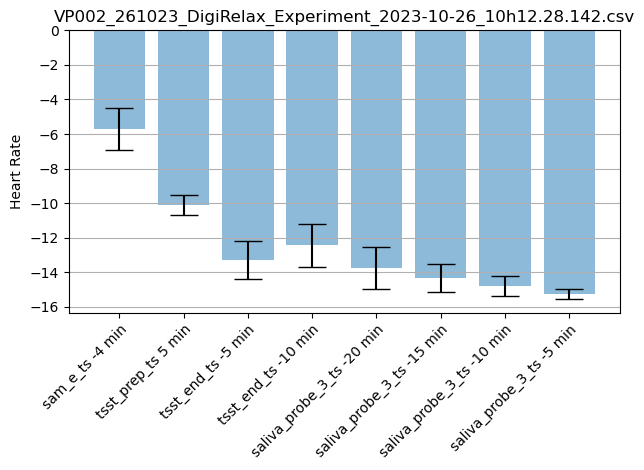

In [8]:
hr_shimmer_df = read_shimmer_sensor(hr_shimmer_file_path)
hr_shimmer_df = standardize_timestamps_shimmer(hr_shimmer_df, "Shimmer_8108_Timestamp_Unix_CAL")
hr_col_interest  = ["Shimmer_8108_Timestamp_Unix_CAL", "Shimmer_8108_ECG_LL-LA_24BIT_CAL"]
hr_shimmer_df_selected =hr_shimmer_df[hr_col_interest]

####-------------------------------

event_interest_list = ["sam_e_ts", "tsst_prep_ts", "tsst_end_ts", "tsst_end_ts", "saliva_probe_3_ts", "saliva_probe_3_ts", "saliva_probe_3_ts", "saliva_probe_3_ts"]
offset_min_list = [-4, 5, -5, -10, -20, -15, -10, -5]
sensor_df= hr_shimmer_df_selected
timestamp_sensor_col_name = "Shimmer_8108_Timestamp_Unix_CAL"
data_col_name = "Shimmer_8108_ECG_LL-LA_24BIT_CAL"
#sensor_df = hr_shimmer_df_selected
mean_list_hr, std_list_hr, event_interest_list_hr = get_mean_std_list_differrent_events(event_interest_list, offset_min_list, psychopy_df, sensor_df, timestamp_sensor_col_name, data_col_name)
y_label_fig = "Heart Rate"
plot_mean_std(mean_list_hr, std_list_hr, event_interest_list_hr, title_figure, y_label_fig)

In [9]:
#### exporting data of interest

In [10]:
export_dict = {"subject_id":title_figure , 'event_interst': event_interest_list_hr, "mean_sk_cond":mean_list_sk , "std_sk_cond": std_list_hr , "mean_hr":mean_list_hr,  "std_hr": std_list_hr}

In [11]:
export_dict

{'subject_id': 'VP002_261023_DigiRelax_Experiment_2023-10-26_10h12.28.142.csv',
 'event_interst': ['sam_e_ts -4 min',
  'tsst_prep_ts 5 min',
  'tsst_end_ts -5 min',
  'tsst_end_ts -10 min',
  'saliva_probe_3_ts -20 min',
  'saliva_probe_3_ts -15 min',
  'saliva_probe_3_ts -10 min',
  'saliva_probe_3_ts -5 min'],
 'mean_sk_cond': [2.4915941495937592,
  4.50776053751466,
  4.560983005483904,
  4.6813242747344015,
  5.939750069838753,
  5.597885658420717,
  5.648936422835684,
  5.933706627652806],
 'std_sk_cond': [1.2264368608782115,
  0.5817479563726525,
  1.0908109721128463,
  1.2343400121950936,
  1.2186801217447034,
  0.8271284740567434,
  0.5642816775369317,
  0.2833204826239789],
 'mean_hr': [-5.714795897337635,
  -10.111136936023188,
  -13.287828864525272,
  -12.447339502247312,
  -13.771544350230828,
  -14.328972651926453,
  -14.799243120205098,
  -15.268452256722075],
 'std_hr': [1.2264368608782115,
  0.5817479563726525,
  1.0908109721128463,
  1.2343400121950936,
  1.2186801217

In [13]:
df_export

,subject_id,event_interst,mean_sk_cond,std_sk_cond,mean_hr,std_hr
0,VP002_261023_DigiRelax_Experiment_2023-10-26_1...,sam_e_ts -4 min,2.491594,1.226437,-5.714796,1.226437
1,VP002_261023_DigiRelax_Experiment_2023-10-26_1...,tsst_prep_ts 5 min,4.507761,0.581748,-10.111137,0.581748
2,VP002_261023_DigiRelax_Experiment_2023-10-26_1...,tsst_end_ts -5 min,4.560983,1.090811,-13.287829,1.090811
3,VP002_261023_DigiRelax_Experiment_2023-10-26_1...,tsst_end_ts -10 min,4.681324,1.234340,-12.447340,1.234340
4,VP002_261023_DigiRelax_Experiment_2023-10-26_1...,saliva_probe_3_ts -20 min,5.939750,1.218680,-13.771544,1.218680
5,VP002_261023_DigiRelax_Experiment_2023-10-26_1...,saliva_probe_3_ts -15 min,5.597886,0.827128,-14.328973,0.827128
6,VP002_261023_DigiRelax_Experiment_2023-10-26_1...,saliva_probe_3_ts -10 min,5.648936,0.564282,-14.799243,0.564282
7,VP002_261023_DigiRelax_Experiment_2023-10-26_1...,saliva_probe_3_ts -5 min,5.933707,0.283320,-15.268452,0.283320


In [163]:
df_export.to_csv(title_figure)